dataset -> 75-25; label >3:+, <=3:-
(u,m) --model--> +/-

u -> similar users (top n) -> one-hot-embedding-clubbed
  -> highly rated movies -> one-hot-encoding-clubbed

m -> users who highly rated this movie -> one-hot-clubbed
  -> similar movies (top p) -> one-hot-clubbed


  

In [1]:
from google.colab import drive 
import pandas as pd

In [ ]:
movies_metadata = pd.read_csv("/content/drive/MyDrive/main/movie_aug_data/movies_metadata-title-fixed.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print(movies_metadata.columns)
movies_metadata.head()

In [ ]:
# removing unwanted columns from movies_metadata
movies_metadata = movies_metadata.drop(columns=["belongs_to_collection",
                                                "budget","homepage","overview",
                                                "poster_path",
                                                "revenue","spoken_languages","status",
                                                "tagline","video"])
movies_metadata = movies_metadata.rename(columns={'id':'the_other_id'})
print(movies_metadata.columns)
movies_metadata.head()

In [ ]:
# fixing release dates to years (so that it can be joined w.r.t [title,year])
# print(movies_metadata["release_date"][0])
years=[]
for i in range(len(movies_metadata)):
  
  dt = str(movies_metadata["release_date"][i])
  if len(dt)>4:
    years.append(dt[-4:])
  else:
    years.append(dt)

movies_metadata["release_date"] = years
movies_metadata = movies_metadata.rename(columns={'release_date':'year'})

In [ ]:
movies_processed = pd.read_csv("/content/drive/MyDrive/main/movie_aug_data/movies_processed-title-fixed.csv")
movies_processed = movies_processed.drop(columns=["Unnamed: 0"])
movies_processed.head()

,id,title,year,genre
0,m1,Toy Story,1995,0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
1,m2,Jumanji,1995,0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
2,m3,Grumpier Old Men,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
3,m4,Waiting to Exhale,1995,0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
4,m5,Father of the Bride Part II,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0


In [ ]:
# converting 'year' values at movies_processed from str to int
for i in range(len(movies_processed)):
  dt = movies_processed["year"][i]
  movies_processed["year"][i] = str(dt)
movies_processed.head()

In [ ]:
movies_processed["year"] = movies_processed["year"].astype("str")

In [ ]:
# fixing title irregularities
movies_processed_title = []
for i in range(len(movies_processed)):
  title = list(movies_processed["title"][i])
  title = list(filter((' ').__ne__,title))
  title= [x.lower() for x in title]
  title = ''.join(title)
  movies_processed_title.append(title)

movies_processed["title_split"]=movies_processed_title

In [ ]:
# fixing title irregularities
movies_metadata_title = []
for i in range(len(movies_metadata)):
  if isinstance(movies_metadata["title"][i],str):
    title = list(movies_metadata["title"][i])
    title = list(filter((' ').__ne__,title))
    title= [x.lower() for x in title]
    title = ''.join(title)
  else:
    title = "no-title"
  movies_metadata_title.append(title)
  # break

movies_metadata["title_split"]=movies_metadata_title

In [ ]:
# merge 1 - wrt [title, year]
movies = pd.merge(movies_processed, movies_metadata, on=['title_split','year'], how='inner')
movies.head()

In [ ]:
print(len(movies_processed))    # total movies we need - 3883
print(len(movies))              # what we got from 1st merge - 3521

3883

## movie problems

#### Problem - Iter 1

In [ ]:
title_problem = pd.merge(movies_processed, movies, on=["title_split"], how='outer', suffixes=('','_y'), indicator=True)
rows_in_df1_not_in_df2 = title_problem[title_problem['_merge']=='left_only'][movies_processed.columns]
print(len(rows_in_df1_not_in_df2)) # number of movie entries missing
# rows_in_df1_not_in_df2
# Problematic movies - ignoring the release year, only wrt titles - duplicates for different release years expected
movies_title_only = pd.merge(rows_in_df1_not_in_df2, movies_metadata, on=['title_split'], how='inner')
movies_title_only.head()

In [ ]:
# collecting movies where release years differed by 1 year
uniques = []
for i in range(len(movies_title_only)):
  year_x = int(movies_title_only["year_x"][i])
  if movies_title_only["year_y"][i]!='nan':
    year_y = int(movies_title_only["year_y"][i])
  else:
    continue
  if abs(year_x-year_y)<=1:
    uniques.append(movies_title_only.iloc[i])

movies_title_only_unique = pd.DataFrame(uniques)
print(len(movies_title_only_unique))
# print(movies_title_only_unique.head(3))

# drop the 2nd year column
movies_title_only_unique = movies_title_only_unique.drop(columns=["year_y"])
movies_title_only_unique = movies_title_only_unique.rename(columns={"year_x":"year"})
movies_title_only_unique.head(3)

267


In [ ]:
# merge 2 - mergeing the movies where release years differed by 1 year
movies_merged = pd.concat([movies,movies_title_only_unique], ignore_index=True)
len(movies_merged)

#### Problems - Iter 2

In [ ]:
# Problems - Iter 2
print(len(movies_processed))
print(len(movies_merged))
title_problem = pd.merge(movies_processed, movies_merged, on=["title_split"], how='outer', suffixes=('','_y'), indicator=True)
print(len(title_problem))
rows_in_df1_not_in_df2 = title_problem[title_problem['_merge']=='left_only'][movies_processed.columns]
len(rows_in_df1_not_in_df2)
rows_in_df1_not_in_df2.index = [i for i in range(len(rows_in_df1_not_in_df2))]

3883
3788
3992


93

In [ ]:
rows_in_df1_not_in_df2

In [ ]:
# collecting movies where release years differed by upto 5 years
movies_more_problems = pd.merge(rows_in_df1_not_in_df2, movies_metadata, on=['title_split'], how='inner')
movies_more_problems.index = [i for i in range(len(movies_more_problems))]
movies_more_problems.head()
uniques = []
for i in range(len(movies_more_problems)):
  year_x = int(movies_more_problems["year_x"][i])
  if movies_more_problems["year_y"][i]!='nan':
    year_y = int(movies_more_problems["year_y"][i])
  else:
    continue
  if abs(year_x-year_y)<=5:
    uniques.append(movies_more_problems.iloc[i])

more_movies = pd.DataFrame(uniques)
print(len(more_movies))

# checking if there are duplicates
more_movies_duplicates = more_movies[more_movies.duplicated(subset=["title_split"], keep=False)]
print(len(more_movies_duplicates)) #no duplicates

more_movies= more_movies.drop(columns=["year_y"])
more_movies = more_movies.rename(columns={"year_x":"year"})
# more_movies.head(3)

40


In [ ]:
# Merge 3 - merging the movies where the release years differed by upto 5 years
movies_merged = pd.concat([movies_merged,more_movies], ignore_index=True)
len(movies_merged)

3828

#### Problem - Iter 3

In [ ]:
print(len(movies_processed))
print(len(movies_merged))
title_problem = pd.merge(movies_processed, movies_merged, on=["title_split"], how='outer', suffixes=('','_y'), indicator=True)
print(len(title_problem))
rows_in_df1_not_in_df2 = title_problem[title_problem['_merge']=='left_only'][movies_processed.columns]
print(len(rows_in_df1_not_in_df2))
# rows_in_df1_not_in_df2.head()

In [ ]:
# finding out the concerned entries by comparing only the titles - duplicates w.r.t release year expected
movies_problem_iter_3 = pd.merge(rows_in_df1_not_in_df2, movies_metadata, on=['title_split'], how='inner')
print(len(movies_problem_iter_3))   # 27
movies_problem_iter_3.head()

In [ ]:
dup = movies_problem_iter_3[movies_problem_iter_3.duplicated(subset="title_split",keep=False)]
print(len(dup)) #11
dup_id =set(list(dup["id"]))

11


In [ ]:
uniques = []
for i in range(len(movies_problem_iter_3)):
  if movies_problem_iter_3["id"][i] in dup_id:
    continue
  else:
    uniques.append(movies_problem_iter_3.iloc[i])

m = pd.DataFrame(uniques)
print(len(m))   # 16
# check if there are any further duplicates
# print(len(m[m.duplicated(subset="title_split",keep=False)]))  # 0 - no duplicates
# m.head()

m = m.drop(columns=["year_y"])
m = m.rename(columns={"year_x":"year"})


16


In [ ]:
# Merge 4 - merging the movies where the release years differed by more than 5 years but had unique titles
movies_merged = pd.concat([movies_merged,m], ignore_index=True)
len(movies_merged)

3844

#### Problem - Iter 4

In [ ]:
print(len(movies_processed))  # 3883
print(len(movies_merged))     # 3844
title_problem = pd.merge(movies_processed, movies_merged, on=["title_split"], how='outer', suffixes=('','_y'), indicator=True)
print(len(title_problem))
rows_in_df1_not_in_df2 = title_problem[title_problem['_merge']=='left_only'][movies_processed.columns]
print(len(rows_in_df1_not_in_df2))
rows_in_df1_not_in_df2.head()

3883
3844
3992
37


,id,title,year,genre,title_split
147,m142,Shadows (Cienie),1988,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,shadows(cienie)
619,m604,Criminals,1996,0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0,criminals
739,m721,Halfmoon (Paul Bowles - Halbmond),1995,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,halfmoon(paulbowles-halbmond)
741,m723,Two Friends,1986,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,twofriends
786,m769,Marlene Dietrich: Shadow and Light,1996,0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0,marlenedietrich:shadowandlight


In [ ]:
movies_processed.loc[movies_processed["title"]=="Criminals"]

,id,title,year,genre,title_split
600,m604,Criminals,1996,0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0,criminals


In [ ]:
movies_metadata.loc[movies_metadata["title"]=="Criminals"]

,adult,genres,the_other_id,imdb_id,original_language,original_title,popularity,production_companies,production_countries,year,runtime,title,vote_average,vote_count,title_split


In [ ]:
rows_in_df1_not_in_df2.to_csv("/content/drive/MyDrive/main/ml-1m/title_problem.csv")

In [ ]:
movies_merged.to_csv("/content/drive/MyDrive/main/movie_aug_data/movies_merged_3844.csv")

user embedding -
* primary attributes (age, gender, occupation, location) - done
* genre preference - done
* similar users (id or their feature vectors)

movie embedding -
* primary attributes
* user-base characteristics
* similar movies (id or their feature vectors)

model (?) takes in embeddings for a user and a movie, predicts the likelihood of a link; loss function compares prediction with ground truth.

## Final - Merged Movies

In [ ]:
movies_processed.head()

,id,title,year,genre,title_split
0,m1,Toy Story,1995,0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0,toystory
1,m2,Jumanji,1995,0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0,jumanji
2,m3,Grumpier Old Men,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0,grumpieroldmen
3,m4,Waiting to Exhale,1995,0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0,waitingtoexhale
4,m5,Father of the Bride Part II,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0,fatherofthebridepartii


In [2]:
movies_final = pd.read_csv("/content/drive/MyDrive/main/movie_aug_data/movies_final.csv")
print(len(movies_final))
movies_final = movies_final.drop(columns="Unnamed: 0")
movies_final.head()

3883


,id,title_x,year,genre,title_split,adult,imdb_id,original_language,original_title,popularity,production_companies,production_countries,runtime,title_y,vote_average,vote_count
0,m1,Toy Story,1995,0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0,toystory,False,tt0114709,en,Toy Story,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81.0,Toy Story,7.7,5415
1,m2,Jumanji,1995,0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0,jumanji,False,tt0113497,en,Jumanji,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104.0,Jumanji,6.9,2413
2,m3,Grumpier Old Men,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0,grumpieroldmen,False,tt0113228,en,Grumpier Old Men,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",101.0,Grumpier Old Men,6.5,92
3,m4,Waiting to Exhale,1995,0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0,waitingtoexhale,False,tt0114885,en,Waiting to Exhale,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",127.0,Waiting to Exhale,6.1,34
4,m5,Father of the Bride Part II,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0,fatherofthebridepartii,False,tt0113041,en,Father of the Bride Part II,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",106.0,Father of the Bride Part II,5.7,173


In [ ]:
movies_final = movies_final.rename(columns={'title_x':'title'})

In [ ]:
df1 = movies_processed
df2 = movies_final
common = df1.merge(df2,on=['id'])
print(len(common))
# col1 = 'title_split'
# df1[(~df1.title.isin(common.title))]

3883


In [ ]:
dup = movies_processed[movies_processed.duplicated(subset=["title_split","year"], keep=False)]
dup

,id,title,year,genre,title_split
1651,m1698,The Boys,1997,0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0,theboys
1690,m1741,Midaq Alley,1995,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,midaqalley
1705,m1758,Dangerous Beauty,1998,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,dangerousbeauty
1735,m1795,Midaq Alley,1995,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,midaqalley
2494,m2563,Dangerous Beauty,1998,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,dangerousbeauty
2626,m2695,The Boys,1997,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,theboys


In [ ]:
dup_final = movies_final[movies_final.duplicated(subset=["title_split","year"], keep=False)]
dup_final

,id,title,year,genre,title_split,adult,imdb_id,original_language,original_title,popularity,production_companies,production_countries,runtime,title_y,vote_average,vote_count
1489,m1698,The Boys,1997,0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0,theboys,False,tt0118764,fr,Les Boys,0.530702,"[{'name': 'Telefilm Canada', 'id': 7320}, {'na...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",107.0,The Boys,5.4,7
1490,m2695,The Boys,1997,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,theboys,False,tt0118764,fr,Les Boys,0.530702,"[{'name': 'Telefilm Canada', 'id': 7320}, {'na...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",107.0,The Boys,5.4,7
1520,m1741,Midaq Alley,1995,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,midaqalley,False,tt0112619,es,Midaq Alley,3.304718,"[{'name': 'Alameda Films', 'id': 300}, {'name'...","[{'iso_3166_1': 'MX', 'name': 'Mexico'}]",140.0,Midaq Alley,6.4,12
1521,m1795,Midaq Alley,1995,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,midaqalley,False,tt0112619,es,Midaq Alley,3.304718,"[{'name': 'Alameda Films', 'id': 300}, {'name'...","[{'iso_3166_1': 'MX', 'name': 'Mexico'}]",140.0,Midaq Alley,6.4,12
1535,m1758,Dangerous Beauty,1998,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,dangerousbeauty,False,tt0118892,en,Dangerous Beauty,4.799270,"[{'name': 'Bedford Falls Productions', 'id': 3...","[{'iso_3166_1': 'US', 'name': 'United States o...",111.0,Dangerous Beauty,6.9,59
1536,m2563,Dangerous Beauty,1998,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0,dangerousbeauty,False,tt0118892,en,Dangerous Beauty,4.799270,"[{'name': 'Bedford Falls Productions', 'id': 3...","[{'iso_3166_1': 'US', 'name': 'United States o...",111.0,Dangerous Beauty,6.9,59


In [ ]:
# print(len(dup_final))
# print(len(movies_final))
# for i in dup_final.index:
#   movies_final = movies_final.drop(labels=i)

# print(len(movies_final))

6
3883
3877


In [ ]:
# movies_final.to_csv("/content/drive/MyDrive/main/movie_aug_data/movies_final.csv")

## Attribute Fixes

In [3]:
movies_final = pd.read_csv("/content/drive/MyDrive/main/movie_aug_data/movies_final.csv")
movies_final = movies_final.drop(columns="Unnamed: 0")
print(len(movies_final))
movies_final.head()

3883


,id,title_x,year,genre,title_split,adult,imdb_id,original_language,original_title,popularity,production_companies,production_countries,runtime,title_y,vote_average,vote_count
0,m1,Toy Story,1995,0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0,toystory,False,tt0114709,en,Toy Story,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81.0,Toy Story,7.7,5415
1,m2,Jumanji,1995,0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0,jumanji,False,tt0113497,en,Jumanji,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104.0,Jumanji,6.9,2413
2,m3,Grumpier Old Men,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0,grumpieroldmen,False,tt0113228,en,Grumpier Old Men,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",101.0,Grumpier Old Men,6.5,92
3,m4,Waiting to Exhale,1995,0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0,waitingtoexhale,False,tt0114885,en,Waiting to Exhale,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",127.0,Waiting to Exhale,6.1,34
4,m5,Father of the Bride Part II,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0,fatherofthebridepartii,False,tt0113041,en,Father of the Bride Part II,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",106.0,Father of the Bride Part II,5.7,173


In [4]:
cols_to_drop = ["title_split","original_title","title_y","popularity","runtime"]
movies_final = movies_final.drop(columns=cols_to_drop)
movies_final = movies_final.rename(columns={'title_x':'title'})
movies_final.head(3)

,id,title,year,genre,adult,imdb_id,original_language,production_companies,production_countries,vote_average,vote_count
0,m1,Toy Story,1995,0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0,False,tt0114709,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",7.7,5415
1,m2,Jumanji,1995,0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0,False,tt0113497,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",6.9,2413
2,m3,Grumpier Old Men,1995,0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0,False,tt0113228,en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",6.5,92


In [ ]:
!pip install OrderedSet

In [5]:
movies = movies_final

In [7]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


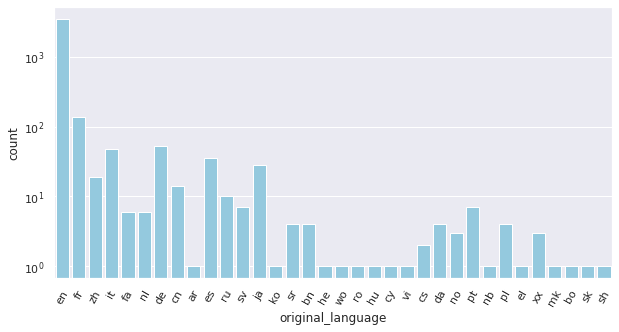

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
p = sns.countplot(movies["original_language"], color="skyblue", ax=ax)
p.set_yscale("log")
plt.xticks(rotation=60)
plt.show()

In [ ]:
import ast
from orderedset import OrderedSet

production = OrderedSet()
prod_id = OrderedSet()
num_of_movies = len(movies)
for i in range(num_of_movies):
    prod_struct = ast.literal_eval(movies["production_companies"][i])
#     print(i)
#     print(prod_struct)
    
    for dct in prod_struct:
        production.add(dct["name"])
        prod_id.add(dct["id"])
print(len(production))
print(len(prod_id))

2810
2825


In [ ]:
prod_countries = []
num_of_movies = len(movies)
count = 0
for i in range(num_of_movies):
    prod_struct = ast.literal_eval(movies["production_countries"][i])
#     print(i)
#     print(prod_struct)
    prod_country = []
    if len(prod_struct)==0:
      pass
      # prod_country = []
    else:
      for country in prod_struct:
        prod_country.append(country["iso_3166_1"])
    prod_countries.append(prod_country)
# print(count)
# prod_countries = sorted(list(prod_countries))
print(len(prod_countries))
# print(len(prod_id))

3883


In [ ]:
movies["production_country_decent"] = prod_countries
movies.head()

In [ ]:
movies = movies.drop(columns=["production_countries"])
movies = movies.rename(columns={'production_country_decent':'prod_country'})
movies.head()

In [ ]:
votes = []
for i in range(len(movies)): 
  v_avg = float(movies["vote_average"][i])
  v_count = int(movies["vote_count"][i])
  v = v_avg*v_count
  votes.append(v)
len(votes)

3883

In [ ]:
movies["vote"]=votes
movies = movies.drop(columns=["vote_average","vote_count"])
movies.head()

In [ ]:
norm_factor = max(movies["vote"])
print(norm_factor)
movies["vote"]=movies["vote"]/norm_factor

1141902.5


In [ ]:
import numpy as np
count = 0
for i in range(len(movies)):
  if isinstance(movies["year"][i],np.int64):
    continue
  else:
    count+=1
count
# type(movies["year"][0])

0

In [ ]:
count = 0
for i in range(len(movies)):
  if isinstance(movies["genre"][i],str):
    continue
  else:
    count+=1
count

0

In [ ]:
genre_col = []
for i in range(len(movies)):
  g = movies["genre"][i]
  g = list(map(int,g.split(' ')))
  genre_col.append(g)

movies["genre"] = genre_col
print(type(movies["genre"][0]))
movies.head()

In [ ]:
movies = movies.drop(columns=["adult","production_companies"])
movies.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

lang = list(set(list(movies["original_language"])))
print(len(lang))    # 34 unique languages

lang = LabelEncoder().fit_transform(movies['original_language'])
lang = OneHotEncoder().fit_transform(lang.reshape(-1, 1)).toarray()
lang_list = []
for i in range(len(lang)):
  lang_list.append(list(lang[i].astype(int)))

movies["lang"] = lang_list
movies.head()

34


,id,title,year,genre,imdb_id,original_language,prod_country,vote,lang
0,m1,Toy Story,1995,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",tt0114709,en,[US],0.036514,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,m2,Jumanji,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",tt0113497,en,[US],0.014581,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,m3,Grumpier Old Men,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",tt0113228,en,[US],0.000524,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,m4,Waiting to Exhale,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",tt0114885,en,[US],0.000182,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,m5,Father of the Bride Part II,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",tt0113041,en,[US],0.000864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [ ]:
movies = movies.drop(columns="original_language")

In [ ]:
prod = list(movies["prod_country"])
# print(len(prod))    # 3873
PRODUCTION_COUNTRIES = list(set([item for sublist in prod for item in sublist]))
print(len(PRODUCTION_COUNTRIES))      # 70
print(PRODUCTION_COUNTRIES)

70
['FR', 'IT', 'VN', 'IL', 'JP', 'RU', 'HR', 'MY', 'TW', 'CZ', 'IR', 'RO', 'SN', 'GR', 'TT', 'CN', 'DK', 'AU', 'LB', 'BA', 'ES', 'MK', 'IS', 'ZA', 'BT', 'HK', 'NZ', 'CU', 'SE', 'BE', 'EC', 'GB', 'KR', 'IN', 'US', 'CD', 'MX', 'KZ', 'DZ', 'PE', 'NL', 'BS', 'NO', 'PT', 'BW', 'JM', 'TN', 'BG', 'UA', 'PH', 'CH', 'BR', 'GE', 'TR', 'DE', 'CA', 'AT', 'PL', 'LI', 'FI', 'IE', 'RS', 'HU', 'CL', 'LU', 'AR', 'AW', 'SI', 'BF', 'DO']


In [ ]:
prod_bins = []
for i in range(len(movies)):
  bin = [0 for _ in range(70)]
  prod_coun = movies['prod_country'][i]
  
  for j in prod_coun:
    bin[PRODUCTION_COUNTRIES.index(j)]=1
  prod_bins.append(bin)

movies["production_country"] = prod_bins
movies.head()

,id,title,year,genre,imdb_id,prod_country,vote,lang,production_country
0,m1,Toy Story,1995,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",tt0114709,[US],0.036514,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,m2,Jumanji,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",tt0113497,[US],0.014581,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,m3,Grumpier Old Men,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",tt0113228,[US],0.000524,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,m4,Waiting to Exhale,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",tt0114885,[US],0.000182,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,m5,Father of the Bride Part II,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",tt0113041,[US],0.000864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
movies = movies.drop(columns='prod_country')

In [ ]:
movies.head()

,id,title,year,genre,imdb_id,vote,lang,production_country
0,m1,Toy Story,1995,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",tt0114709,0.086054,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,m2,Jumanji,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",tt0113497,0.034363,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,m3,Grumpier Old Men,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",tt0113228,0.001234,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,m4,Waiting to Exhale,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",tt0114885,0.000428,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,m5,Father of the Bride Part II,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",tt0113041,0.002035,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# movies.to_csv("/content/drive/MyDrive/main/movie_aug_data/movies_one_hot_encoded.csv", index=False)

In [ ]:
movies_one_hot = pd.read_csv("/content/drive/MyDrive/main/movie_aug_data/movies_one_hot_encoded.csv")

In [ ]:
movies["normed_year"]=(movies["year"]-movies["year"].min())/(movies["year"].max()-movies["year"].min())
movies.head()

In [ ]:
feature_vector = []
for i in range(len(movies)):
  fv = []
  year = int(movies["year"][i])
  fv.append(year)
  genre = movies["genre"][i] 
  fv.extend(genre)
  
  vote = float(movies["vote"][i]) 
  fv.append(vote)
  lang = list(map(int,movies["lang"][i]))
  fv.extend(lang)
  prod = movies["production_country"][i] 
  fv.extend(prod)
  # fv = list(movies["year"][i])+movies["genre"][i]+list(movies["vote"][i])+movies["lang"][i]+movies["production_country"][i]
  feature_vector.append(fv)

movies["feature_vector"] = feature_vector
movies = movies.drop(columns=["year","genre","vote","lang","production_country"])
movies.head()

,id,title,imdb_id,feature_vector
0,m1,Toy Story,tt0114709,"[1995, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,m2,Jumanji,tt0113497,"[1995, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,m3,Grumpier Old Men,tt0113228,"[1995, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,m4,Waiting to Exhale,tt0114885,"[1995, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,m5,Father of the Bride Part II,tt0113041,"[1995, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
movies.to_csv("/content/drive/MyDrive/main/movie_aug_data/movies_feature_vectors.csv", index=False)

In [ ]:
movie_id_reqd = set(list(movies_processed["id"]))
print(len(movie_id_reqd))
movie_id_obt = set(list(movies["id"]))
print(len(movie_id_obt))

movie_id_rem = list(movie_id_reqd.difference(movie_id_obt))
print(len(movie_id_rem))
print(movie_id_rem)

3883
3883
0
[]


## Movie Similarity

In [ ]:
movies = pd.read_csv("/content/drive/MyDrive/main/movie_aug_data/movies_feature_vectors.csv")

In [ ]:
print(len(movies))
movies.head()

3883


,id,title,year,imdb_id,feature_vector
0,m1,Toy Story,1995,tt0114709,"[0.9382716049382716, 0, 0, 1, 1, 1, 0, 0, 0, 0..."
1,m2,Jumanji,1995,tt0113497,"[0.9382716049382716, 0, 1, 0, 1, 0, 0, 0, 0, 1..."
2,m3,Grumpier Old Men,1995,tt0113228,"[0.9382716049382716, 0, 0, 0, 0, 1, 0, 0, 0, 0..."
3,m4,Waiting to Exhale,1995,tt0114885,"[0.9382716049382716, 0, 0, 0, 0, 1, 0, 0, 1, 0..."
4,m5,Father of the Bride Part II,1995,tt0113041,"[0.9382716049382716, 0, 0, 0, 0, 1, 0, 0, 0, 0..."


In [ ]:
from scipy import spatial
import numpy as np
import ast
def movie_feature_similarity(m,n):
  m_index = movies.index[movies['id'] == m].to_list()[0]
  m_feature = ast.literal_eval(movies["feature_vector"][m_index])
  n_index = movies.index[movies['id'] == n].to_list()[0]
  n_feature = ast.literal_eval(movies["feature_vector"][n_index])
  m_feature = np.array(m_feature)
  n_feature = np.array(n_feature)
  return (1 - spatial.distance.cosine(m_feature,n_feature))

In [ ]:
movie_feature_similarity('m1','m3')

0.724263895249819

In [ ]:
MOVIE_IDS = list(movies["id"])
print(len(MOVIE_IDS))
MOVIE_IDS[:10]

3883


['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10']

In [ ]:
from heapq import nlargest
import itertools
count = 0
num = 10
movie_similarity = []
for i in range(len(movies)):
  m = movies["id"][i]
  similar_movies = {}
  for n in MOVIE_IDS:
    if m==n:
      continue
    else:
      sim = movie_feature_similarity(m,n)
      similar_movies[n]=sim
  
  top_n = nlargest(num, similar_movies, key = similar_movies.get)
  movie_similarity.append([m,top_n])
  count +=1
  if count%100==0:
    print("Done with", count, "movies")

movies_top_10_similar = pd.DataFrame(movie_similarity, columns=["movie_id","top_10_movies"])
movies_top_10_similar.to_csv("/content/drive/MyDrive/main/movie_aug_data/movies_top_10_similar.csv",index=False)
print(len(movies_top_10_similar))
movies_top_10_similar.head()

Done with 100 movies
Done with 200 movies
Done with 300 movies
Done with 400 movies
Done with 500 movies
Done with 600 movies
Done with 700 movies
Done with 800 movies
Done with 900 movies
Done with 1000 movies
Done with 1100 movies
Done with 1200 movies
Done with 1300 movies
Done with 1400 movies
Done with 1500 movies
Done with 1600 movies
Done with 1700 movies
Done with 1800 movies
Done with 1900 movies
Done with 2000 movies
Done with 2100 movies
Done with 2200 movies
Done with 2300 movies
Done with 2400 movies
Done with 2500 movies
Done with 2600 movies
Done with 2700 movies
Done with 2800 movies
Done with 2900 movies
Done with 3000 movies
Done with 3100 movies
Done with 3200 movies
Done with 3300 movies
Done with 3400 movies
Done with 3500 movies
Done with 3600 movies
Done with 3700 movies
Done with 3800 movies
3883


,movie_id,top_10_movies
0,m1,"[m1064, m2355, m3114, m2354, m2142, m2141, m36..."
1,m2,"[m60, m2005, m2399, m1009, m2043, m1881, m1750..."
2,m3,"[m93, m237, m3046, m294, m295, m339, m39, m708..."
3,m4,"[m72, m322, m562, m45, m3477, m864, m1392, m14..."
4,m5,"[m52, m186, m38, m203, m585, m176, m1166, m156..."


In [ ]:
movie_similarity

[['m1064',
  'm2355',
  'm3114',
  'm2354',
  'm2142',
  'm2141',
  'm3611',
  'm3754',
  'm239',
  'm588']]

In [ ]:
d

{'m10': 0.4528203820283162,
 'm11': 0.6598165637013667,
 'm2': 0.6598882024746687,
 'm3': 0.724263895249819,
 'm4': 0.7242615819129132,
 'm5': 0.8122471360514403,
 'm6': 0.4898433021096281,
 'm7': 0.6598143229740466,
 'm8': 0.7242617934738591,
 'm9': 0.6029256769232845}

In [ ]:
top_n = nlargest(5, d, key=d.get)
top_n

['m5', 'm3', 'm8', 'm4', 'm2']

In [ ]:
sorted(d, key=d.get, reverse=True)[:5]

['m5', 'm3', 'm8', 'm4', 'm2']